In [1]:
import nltk
import pandas as pd
import json

df_train = pd.read_json('train.json')
df_test = pd.read_json('test.json')


C:\Program Files (x86)\pit\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# drop the original 'data' column
df = df_train.copy()
df.drop(['extracted_part', "id"], axis=1, inplace=True)
df

,text,label
0,Извещение о проведении открытого конкурса в эл...,обеспечение исполнения контракта
1,ТРЕБОВАНИЯ К СОДЕРЖАНИЮ ЗАЯВКИ участника запро...,обеспечение исполнения контракта
2,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта
3,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта
4,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта
...,...,...
1794,"«УТВЕРЖДАЮ» Директор МУП ""ПКП и ОРТ"" _________...",обеспечение гарантийных обязательств
1795,ФЕДЕРАЛЬНОЕ ГОСУДАРСТВЕННОЕ УНИТАРНОЕ ПРЕДПРИЯ...,обеспечение гарантийных обязательств
1796,ДОГОВОР ПОДРЯДА № _____ «___»___________20____...,обеспечение гарантийных обязательств
1797,ДОКУМЕНТАЦИЯ О ЗАКУПКЕ ЗАПРОС ПРЕДЛОЖЕНИЙ В ЭЛ...,обеспечение гарантийных обязательств


### Попробуем реализовать "кот в мешке"
Наша задача - сделать модель которая получает вектор данных текста на вход и определяет Label

Забинарим label

In [3]:
first, second = df.label.unique()
info = {first: 0,
       second: 1}

df['label'] = df.label.map(info)
df

,text,label
0,Извещение о проведении открытого конкурса в эл...,0
1,ТРЕБОВАНИЯ К СОДЕРЖАНИЮ ЗАЯВКИ участника запро...,0
2,Извещение о проведении электронного аукциона д...,0
3,Извещение о проведении электронного аукциона д...,0
4,Извещение о проведении электронного аукциона д...,0
...,...,...
1794,"«УТВЕРЖДАЮ» Директор МУП ""ПКП и ОРТ"" _________...",1
1795,ФЕДЕРАЛЬНОЕ ГОСУДАРСТВЕННОЕ УНИТАРНОЕ ПРЕДПРИЯ...,1
1796,ДОГОВОР ПОДРЯДА № _____ «___»___________20____...,1
1797,ДОКУМЕНТАЦИЯ О ЗАКУПКЕ ЗАПРОС ПРЕДЛОЖЕНИЙ В ЭЛ...,1


Теперь нужно закодировать текст

In [4]:
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize, MWETokenizer, RegexpTokenizer, word_tokenize
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict, Counter


## Токенизируем текст

In [5]:
morph = MorphAnalyzer()
russian_stopwords = stopwords.words("russian")
more_stops = [',', '(', ')', '.', '``', "''", ':', ';', '«', '»', '___', '[', ']']
russian_stopwords.extend(more_stops)

def clean_words(x):
    
    words = word_tokenize(x)

    word_list = []
    for i in range(len(words)):
        w = morph.normal_forms(words[i])[0]
        if w not in russian_stopwords and '_' not in w :
            word_list.append(w)
            
    return word_list

In [6]:
words_dict_all = defaultdict(int)

df_all = df.copy()
df_all.text = df_all.text.apply(clean_words)

Создаём словарь всех слов

In [7]:
words_dict = defaultdict(int)

for line in df_all.text:
    for i in line:
        words_dict[i] += 1
    
keys = sorted(words_dict.items(), key=lambda x: x[1], reverse=True)
keys

[('обеспечение', 12488),
 ('контракт', 10957),
 ('исполнение', 9482),
 ('договор', 8227),
 ('закупка', 7565),
 ('заказчик', 5095),
 ('обязательство', 4977),
 ('требование', 4696),
 ('гарантия', 4624),
 ('гарантийный', 3763),
 ('№', 3706),
 ('счёт', 3646),
 ('размер', 3646),
 ('товар', 3607),
 ('срок', 3605),
 ('участник', 3528),
 ('который', 3464),
 ('цена', 3399),
 ('соответствие', 3355),
 ('закон', 3233),
 ('независимый', 2772),
 ('поставщик', 2764),
 ('средство', 2760),
 ('работа', 2739),
 ('предоставление', 2730),
 ('электронный', 2535),
 ('случай', 2508),
 ('заявка', 2477),
 ('услуга', 2376),
 ('1', 2304),
 ('извещение', 2280),
 ('номер', 2275),
 ('%', 2123),
 ('настоящий', 2093),
 ('федеральный', 2077),
 ('денежный', 2060),
 ('статья', 2052),
 ('44-фз', 1939),
 ('г.', 1919),
 ('российский', 1888),
 ('предусмотреть', 1833),
 ('порядок', 1784),
 ('информация', 1781),
 ('должный', 1734),
 ('форма', 1728),
 ('начальный', 1701),
 ('максимальный', 1694),
 ('государственный', 1692),
 ('

Теперь выделим главные слова

In [8]:
counts = sorted(list(words_dict.values()), reverse=True)
counts = counts[0:1000]

r = pd.Series(counts)
r.describe()

count     1000.000000
mean       365.020000
std        918.668039
min         31.000000
25%         50.000000
50%         97.000000
75%        274.250000
max      12488.000000
dtype: float64

<AxesSubplot:>

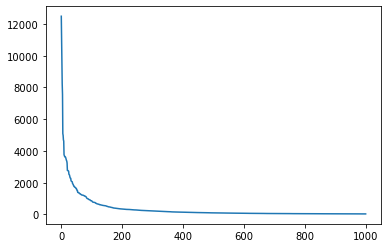

In [9]:
import seaborn as sns
# sns.histplot(list(words_dict.values()))
import matplotlib.pyplot as plt
x = list(r.index)
y = r
sns.lineplot(x=x, y=y)

In [10]:
counts

[12488,
 10957,
 9482,
 8227,
 7565,
 5095,
 4977,
 4696,
 4624,
 3763,
 3706,
 3646,
 3646,
 3607,
 3605,
 3528,
 3464,
 3399,
 3355,
 3233,
 2772,
 2764,
 2760,
 2739,
 2730,
 2535,
 2508,
 2477,
 2376,
 2304,
 2280,
 2275,
 2123,
 2093,
 2077,
 2060,
 2052,
 1939,
 1919,
 1888,
 1833,
 1784,
 1781,
 1734,
 1728,
 1701,
 1694,
 1692,
 1657,
 1610,
 1608,
 1547,
 1501,
 1500,
 1387,
 1384,
 1378,
 1374,
 1363,
 1318,
 1315,
 1311,
 1305,
 1275,
 1267,
 1250,
 1244,
 1224,
 1224,
 1218,
 1216,
 1215,
 1207,
 1191,
 1189,
 1178,
 1167,
 1167,
 1140,
 1132,
 1131,
 1108,
 1092,
 1044,
 1024,
 1001,
 995,
 984,
 983,
 958,
 952,
 934,
 930,
 923,
 916,
 901,
 869,
 867,
 866,
 860,
 851,
 827,
 803,
 779,
 774,
 770,
 764,
 761,
 755,
 753,
 747,
 746,
 726,
 702,
 702,
 697,
 679,
 668,
 662,
 652,
 650,
 646,
 645,
 642,
 636,
 615,
 614,
 612,
 612,
 603,
 594,
 593,
 590,
 583,
 577,
 571,
 569,
 567,
 567,
 567,
 555,
 554,
 550,
 549,
 543,
 543,
 540,
 535,
 524,
 515,
 507,
 506,


Выберем число 300 - довольно часто встречающиеся слова

In [11]:
main_dict = keys[:300]
k = [i[0] for i in main_dict]
v = [i[1] for i in main_dict]
main_dict = dict(zip(k, v))

In [12]:
cnt = Counter

def count_cat(x):
    cat_now = dict.fromkeys(k, 0)
    for word in x:
        if word in k:
            cat_now[word] += 1

    return cat_now
    
df_all['info'] = df_all.text.apply(count_cat)
df_all

,text,label,info
0,"[извещение, проведение, открытый, конкурс, эле...",0,"{'обеспечение': 10, 'контракт': 8, 'исполнение..."
1,"[требование, содержание, заявка, участник, зап...",0,"{'обеспечение': 5, 'контракт': 7, 'исполнение'..."
2,"[извещение, проведение, электронный, аукцион, ...",0,"{'обеспечение': 9, 'контракт': 8, 'исполнение'..."
3,"[извещение, проведение, электронный, аукцион, ...",0,"{'обеспечение': 8, 'контракт': 9, 'исполнение'..."
4,"[извещение, проведение, электронный, аукцион, ...",0,"{'обеспечение': 13, 'контракт': 13, 'исполнени..."
...,...,...,...
1794,"[утверждать, директор, муп, пкп, орт, а.и, биб...",1,"{'обеспечение': 4, 'контракт': 0, 'исполнение'..."
1795,"[федеральный, государственный, унитарный, пред...",1,"{'обеспечение': 0, 'контракт': 0, 'исполнение'..."
1796,"[договор, подряд, №, пао, россеть, северо-запа...",1,"{'обеспечение': 0, 'контракт': 0, 'исполнение'..."
1797,"[документация, закупка, запрос, предложение, э...",1,"{'обеспечение': 0, 'контракт': 0, 'исполнение'..."


In [13]:
df_targets = df_all['info'].apply(pd.Series)
df_full = pd.concat([df_all.drop(['info', 'text'], axis=1), df_targets], axis=1)
df_full

,label,обеспечение,контракт,исполнение,договор,закупка,заказчик,обязательство,требование,гарантия,...,выплата,медицинский,край,конкурс,десять,8.1,подписать,цель,--,00
0,0,10,8,7,1,9,2,3,5,8,...,0,0,0,2,0,0,0,0,0,0
1,0,5,7,4,1,2,3,0,3,1,...,0,0,0,0,0,0,0,0,0,0
2,0,9,8,6,0,7,3,1,7,1,...,0,0,0,0,0,0,0,0,0,0
3,0,8,9,7,0,7,2,1,3,7,...,0,0,0,0,0,0,0,0,0,0
4,0,13,13,8,0,8,1,2,3,2,...,0,0,3,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1794,1,4,0,5,9,2,4,2,4,1,...,0,0,0,0,0,0,0,0,0,1
1795,1,0,0,0,2,7,0,0,5,0,...,0,0,0,0,0,0,0,0,0,0
1796,1,0,0,1,7,2,2,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1797,1,0,0,1,4,6,1,0,2,0,...,0,0,0,0,0,0,0,0,0,0


## Обучение модели
Мы выделили признаки - осталось обучить модель

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [22]:
X = df_full.drop('label', axis=1)
y = df_full['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [29]:
LR = LogisticRegression()
LR.fit(X_train, y_train)

res = LR.predict(X_test)


C:\Program Files (x86)\pit\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [30]:
accuracy_score(y_test, res), f1_score(y_test, res)

(0.9494949494949495, 0.9440298507462687)

In [31]:
LR.fit(X, y)

C:\Program Files (x86)\pit\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

### Валидация

In [32]:
df_p = df_test.copy()
df_p.text = df_p.text.apply(clean_words)
df_p

,id,text,label
0,762883279,"[муниципальный, контракт, №, оказание, услуга,...",обеспечение исполнения контракта
1,311837655,"[извещение, проведение, электронный, аукцион, ...",обеспечение исполнения контракта
2,540954893,"[идентификационный, код, закупка, 222633005300...",обеспечение исполнения контракта
3,274660397,"[идентификационный, код, закупка, 222631202689...",обеспечение исполнения контракта
4,732742591,"[идентификационный, код, закупка, 222637800031...",обеспечение исполнения контракта
...,...,...,...
313,854936033,"[федеральный, государственный, унитарный, пред...",обеспечение гарантийных обязательств
314,576390745,"[часть, iii, проект, договор, договор, поставк...",обеспечение гарантийных обязательств
315,323745820,"[утверждать, председатель, единый, комиссия, о...",обеспечение гарантийных обязательств
316,712286194,"[версия, 04.07.2022, год, р, далее, ю, государ...",обеспечение гарантийных обязательств


In [33]:
def count_cat(x):
    cat_now = dict.fromkeys(k, 0)
    for word in x:
        if word in k:
            cat_now[word] += 1

    return cat_now

In [34]:

df_p['info'] = df_p.text.apply(count_cat)

df_info = df_p['info'].apply(pd.Series)
df_p_full = pd.concat([df_p.drop(['info', 'text', 'id'], axis=1), df_info], axis=1)
df_p_full

,label,обеспечение,контракт,исполнение,договор,закупка,заказчик,обязательство,требование,гарантия,...,выплата,медицинский,край,конкурс,десять,8.1,подписать,цель,--,00
0,обеспечение исполнения контракта,9,11,6,0,6,4,0,2,2,...,0,0,0,0,0,0,0,0,0,0
1,обеспечение исполнения контракта,10,18,7,0,6,1,2,4,4,...,0,2,0,0,0,0,0,0,0,0
2,обеспечение исполнения контракта,10,13,6,0,5,4,1,2,1,...,0,0,0,0,0,1,0,0,0,0
3,обеспечение исполнения контракта,10,13,6,0,5,4,1,2,1,...,0,0,0,0,0,1,0,0,0,0
4,обеспечение исполнения контракта,10,13,6,0,5,5,1,2,1,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,обеспечение гарантийных обязательств,1,0,0,1,6,0,0,6,0,...,0,0,0,0,0,0,0,0,0,0
314,обеспечение гарантийных обязательств,13,0,9,15,4,3,9,3,2,...,0,0,0,0,1,0,0,0,0,0
315,обеспечение гарантийных обязательств,1,0,0,2,7,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
316,обеспечение гарантийных обязательств,8,0,5,6,8,4,3,2,0,...,0,2,0,0,0,0,1,0,0,0


In [35]:
first, second = df_p_full.label.unique()
info = {first: 0,
       second: 1}

df_p_full['label'] = df_p_full.label.map(info)
df_p_full

,label,обеспечение,контракт,исполнение,договор,закупка,заказчик,обязательство,требование,гарантия,...,выплата,медицинский,край,конкурс,десять,8.1,подписать,цель,--,00
0,0,9,11,6,0,6,4,0,2,2,...,0,0,0,0,0,0,0,0,0,0
1,0,10,18,7,0,6,1,2,4,4,...,0,2,0,0,0,0,0,0,0,0
2,0,10,13,6,0,5,4,1,2,1,...,0,0,0,0,0,1,0,0,0,0
3,0,10,13,6,0,5,4,1,2,1,...,0,0,0,0,0,1,0,0,0,0
4,0,10,13,6,0,5,5,1,2,1,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,1,1,0,0,1,6,0,0,6,0,...,0,0,0,0,0,0,0,0,0,0
314,1,13,0,9,15,4,3,9,3,2,...,0,0,0,0,1,0,0,0,0,0
315,1,1,0,0,2,7,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
316,1,8,0,5,6,8,4,3,2,0,...,0,2,0,0,0,0,1,0,0,0


In [36]:
X_predict = df_p_full.drop('label', axis=1)

res_all = LR.predict(X_predict)
y_true = df_p_full['label']

accuracy_score(y_test, res), f1_score(y_test, res)

(0.9494949494949495, 0.9440298507462687)

In [37]:
df_full.to_csv('train_nlp.csv', index=False)

In [38]:
df_p_full

,label,обеспечение,контракт,исполнение,договор,закупка,заказчик,обязательство,требование,гарантия,...,выплата,медицинский,край,конкурс,десять,8.1,подписать,цель,--,00
0,0,9,11,6,0,6,4,0,2,2,...,0,0,0,0,0,0,0,0,0,0
1,0,10,18,7,0,6,1,2,4,4,...,0,2,0,0,0,0,0,0,0,0
2,0,10,13,6,0,5,4,1,2,1,...,0,0,0,0,0,1,0,0,0,0
3,0,10,13,6,0,5,4,1,2,1,...,0,0,0,0,0,1,0,0,0,0
4,0,10,13,6,0,5,5,1,2,1,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,1,1,0,0,1,6,0,0,6,0,...,0,0,0,0,0,0,0,0,0,0
314,1,13,0,9,15,4,3,9,3,2,...,0,0,0,0,1,0,0,0,0,0
315,1,1,0,0,2,7,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
316,1,8,0,5,6,8,4,3,2,0,...,0,2,0,0,0,0,1,0,0,0


In [39]:
df_p_full.to_csv('test_nlp.csv', index=False)

# Супер ! Мы реализовали кота в мешке!